<img src = "https://www.olimpiadadeinformatica.org.mx/Resultados/img/escuelas/401.png" width = "200" style = "display: block; margin-left: auto; margin-right: auto;"/>

<h2> <div align="center"> MR4010.10 </div> </h2>
<h2> <div align="center"> Navegación Autónoma </div> </h2>
<h3> <div align="center"> Dr. David Antonio Torres </div> </h3>
<h3> <div align="center"> Mtra. María Mylen Treviño E. </div> </h3>
<h2> <div align="center"> Actividad 3.1 - Detección de Peatones con SVM </div> </h2>
<h3> <div align="center"> Equipo 14 </div> </h3>
<div align="center"> Ada Jimena Vargas Aguirre                     A01701619 </div> 
<div align="center"> Luis Daniel Barrionuevo Llerena               A00826282 </div> 
<div align="center"> Kevin Gutiérrez Pérez                         A01795692 </div> 
<div align="center"> Ignacio Garay Ruiz                            A01795753 </div> 
<div align="right"> 18 de mayo del 2025 </div> 

# Actividad 3.1 - Detección de Peatones con SVM
**Enlace a video demostrativo:**

### Base de datos empleada en esta actividad:
* INRIA Person, un dataset de imágenes de personas usado para detección de peatones. Originalmente consiste de 614 reconocimientos de peatones para entrenamiento y 288 para pruebas. Fue introducido por Navneet Dalal et al. en Histograms of Oriented Gradients for Human Detection
https://paperswithcode.com/dataset/inria-person

* Link de descarga del dataset usado:
https://huggingface.co/datasets/marcelarosalesj/inria-person/tree/main

**NOTA**: El dataset descargado es una modificación del original, ya que este sí contiene imágenes sin peatones y está claramente organizado en 2 carpetas "pedestrian" y "no_pedestrians".

# Importar bibliotecas necesarias

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

import cv2
from skimage.feature import hog

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

# Importar datasets

In [2]:
import glob
# Se obtiene una lista de rutas de archivos que coinciden con el patrón especificado para cada grupo.
pedestrian = glob.glob("inria-person/data_ped/pedestrians/*.png")
non_pedestrian = glob.glob("inria-person/data_ped/no_pedestrians/*.png")

In [3]:
print(f"{len(pedestrian)} imágenes con peatones")
print(f"{len(non_pedestrian)} imágenes sin peatones")

1269 imágenes con peatones
912 imágenes sin peatones


### Leer imagen 
Se corrobora la información

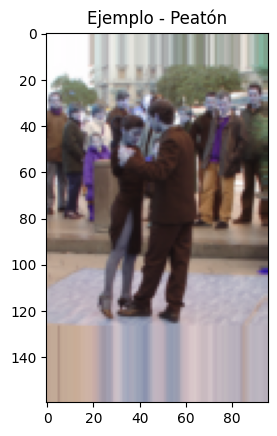

In [4]:
img_color1 = cv2.imread(pedestrian[1])
plt.imshow(img_color1)
plt.title("Ejemplo - Peatón")
#plt.axis('off')
plt.show()

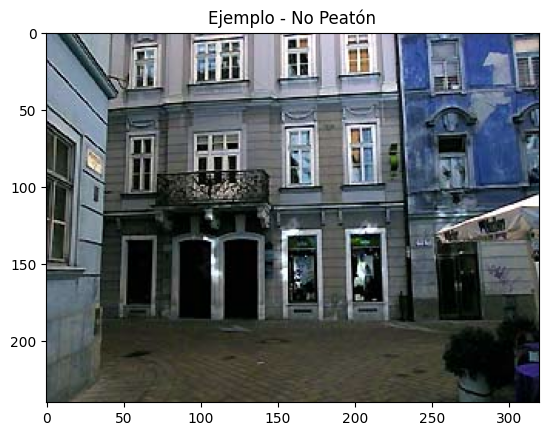

In [5]:
img_color2 = cv2.imread(non_pedestrian[100])
plt.imshow(img_color2)
plt.title("Ejemplo - No Peatón")
#plt.axis('off')
plt.show()

# Preprocesamiento y extracción de características HOG

Función que extrae características HOG (Histogram of Oriented Gradients) de un cojunto de imágenes.

Argumentos:
* img_group : Lista con rutas de imágenes a procesar.
* label : Etiqueta que se asignará a todas las imágenes (1 para presencia de peatón, 0 para ausencia de peatón)
* size : Tamaño al cual se quiere redimensionar todas las imágenes (ancho, alto).


Retorna:   
* X : Matriz Numpy donde se almacenan los vectores de características HOG de cada imagen.
* y : Vector de etiquetas del mismo largo que X
* visuals : Lista de imágenes con la visualización del gradiente HOG.

In [6]:
"""
PRIMERA MODIFICACIÓN

La primera modificación, con respecto al código presentado para la detección de vehículos,
fue realizar el preprocesamiento y extracción de características HOG por medio de una función
para ambos tipos de datos.

"""

def hog_features_extraction(img_group,label, size = (64,128)):
    features = []              # Lista para almacenar los vectores HOG
    visuals = []               # Lista para almacenar las imágenes HOG
    
    for img in img_group:
        img_color = mpimg.imread(img)                             # Leer imagen a color
        img_gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)    # Convertir a escala de grises
        img_resized = cv2.resize(img_gray, size)                  # Redimensionar imagen para normalizar el formato entre imágenes


        """
        SEGUNDA MODIFICACIÓN

        Se optó por redimensionar todas las imágenes a una resolución de
        64 x 128 porque se ha convertido en un estándar de facto para la
        detección de peatones a partir del trabajo de Dalal y Triggs (2005),
        donde se observó que este tamaño de ventana incluye aprox. 16 píxeles de
        margen alrededor del cuerpo de un persona (por cada lado).

        Dicho margen sirve de contexto visual (ej.: bordes, fondo, sombras, piso,
        etc.), y en el artículo mencionado se demostró que este contexto
        contribuyó a una mejor detección.
        
        """
        
       # Extraer características HOG y la respectiva imagen del gradiente 
        element_hog_feature, element_hog_img = hog(img_resized,    # Imagen de entrada, en escala de grises y redimensionada
                                orientations = 11,                 # Número de bins para el histograma de gradientes    
                                pixels_per_cell = (16,16),         # Tamaño de cada celda para calcular el histograma (en píxeles)
                                cells_per_block = (2,2),           # Número de celdas que conforman un bloque para normalizar localmente
                                transform_sqrt = False,            # Si True = mejora la normalización del contraste
                                visualize = True,                  # Devuelve imagen HOG (solo para visualización)
                                feature_vector = True)             # Devuelve las características HOG como un vector (será lo que se le alimentará al modelo SVM)

        features.append(element_hog_feature)     # Agregar vector HOG a la lista
        
        visuals.append(element_hog_img)          # Agregar imagen HOG a la lista (representación visual de HOG)

    X = np.vstack(features).astype(np.float64)     # Convertir en matriz de características, cada fila es un vector HOG que representa cada imagen
    y = np.full(len(X),label)                    # Vector de etiquetas
        
    return X, y, visuals           

## Extracción para grupo 1 (peatones)

In [7]:
X_pedestrian, y_pedestrian, visuals_pedestrian = hog_features_extraction(pedestrian,1)

In [8]:
X_pedestrian.shape

(1269, 924)

In [9]:
y_pedestrian.shape

(1269,)

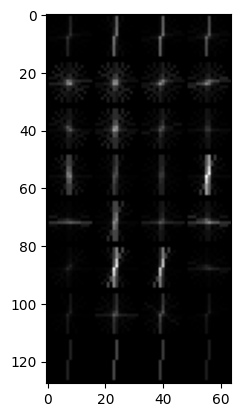

In [10]:
# Veamos un ejemplo
plt.imshow(visuals_pedestrian[1], cmap = 'gray')
plt.show()

## Extracción para grupo 2 (no peatones)

In [11]:
X_nopedestrian, y_nopedestrian, visuals_nopedestrian = hog_features_extraction(non_pedestrian,0)

In [12]:
X_nopedestrian.shape

(912, 924)

In [13]:
y_nopedestrian.shape

(912,)

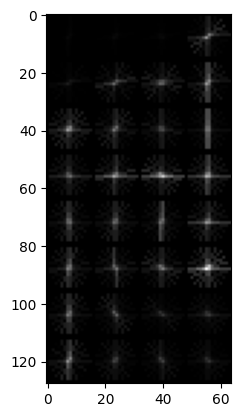

In [14]:
# Veamos un ejemplo
plt.imshow(visuals_nopedestrian[1], cmap = 'gray')
plt.show()

# Preparar datos para el clasificador

## Combinar ambas clases
Se preparan para poder ser suministrados al SVM

In [15]:
X = np.vstack((X_pedestrian, X_nopedestrian))
X.shape

(2181, 924)

In [16]:
y = np.hstack((y_pedestrian, y_nopedestrian))
y.shape

(2181,)

## Generar particiones de entrenamiento y de prueba

In [17]:
X_train,X_test,y_train,y_test = train_test_split(X, y, train_size = 0.7, random_state = 42)

In [18]:
X_train.shape

(1526, 924)

In [19]:
X_test.shape

(655, 924)

# Entrenamiento del clasificador

In [20]:
svc_model = SVC()
svc_model.fit(X_train, y_train)

SVC()

In [21]:
y_predict = svc_model.predict(X_test)

<Axes: >

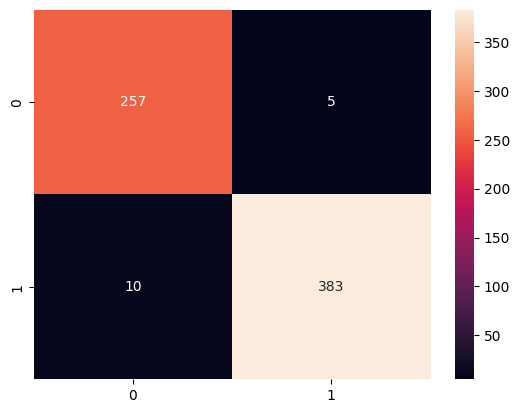

In [22]:
cm = confusion_matrix(y_test, y_predict)
sns.heatmap(cm, annot = True, fmt = 'd')

In [23]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       262
           1       0.99      0.97      0.98       393

    accuracy                           0.98       655
   macro avg       0.97      0.98      0.98       655
weighted avg       0.98      0.98      0.98       655



## Probar con parámetros determinados con GridSearchCV

In [24]:
param_grid = {'C':[0.1,1,10,100,1000], 'gamma':[1,0.1,0.01,0.001,0.0001],'kernel': ['rbf']}

In [25]:
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 4)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.575 total time=   0.8s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.574 total time=   0.8s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.574 total time=   1.2s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.574 total time=   0.9s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.574 total time=   0.9s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.944 total time=   0.6s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.951 total time=   0.7s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.928 total time=   0.5s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.941 total time=   0.6s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.928 total time=   0.5s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.663 total time=   0.6s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=4)

In [27]:
grid.best_params_

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

In [28]:
grid.best_estimator_

SVC(C=10, gamma=0.1)

In [29]:
grid_predictions = grid.predict(X_test)

<Axes: >

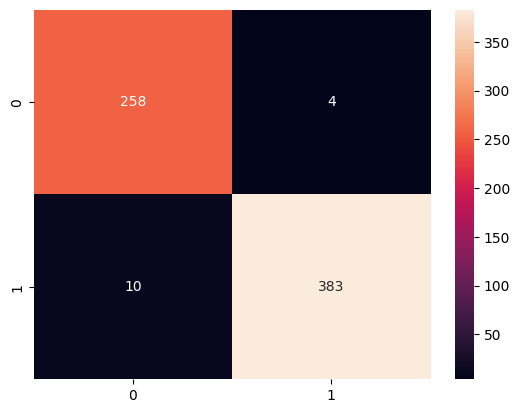

In [30]:
cm = confusion_matrix(y_test, grid_predictions)
sns.heatmap(cm, annot = True, fmt= 'd')

In [31]:
print(classification_report(y_test, grid_predictions))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       262
           1       0.99      0.97      0.98       393

    accuracy                           0.98       655
   macro avg       0.98      0.98      0.98       655
weighted avg       0.98      0.98      0.98       655



# Conclusiones

Se consiguió implementar un sistema de detección de peatones utilizando un clasificador SVM. Uno de los pasos clave fue el preprocesamiento de las imágenes, donde tuvimos que ajustar su tamaño para que el descriptor HOG pudiera extraer características de forma más eficiente.
Los resultados obtenidos fueron bastante satisfactorios, alcanzando una precisión del 98% en el conjunto de prueba, con métricas de precision, recall y f1-score igualmente altas para ambas clases. Esto demuestra que el modelo logró diferenciar correctamente entre imágenes con peatones y sin peatones en la mayoría de los casos.

# Bibliografía

Dalal, N., & Triggs, B. (2005). "Histograms of Oriented Gradients for Human Detection". IEEE Computer Society Conference on Computer Vision and Pattern Recognition (CVPR). https://lear.inrialpes.fr/people/triggs/pubs/Dalal-cvpr05.pdf